    Jacob Knopping
    1/6/2020

# 16.10 Challenge

In [1]:
#Import libraries that may be needed:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

## Loading the dataset

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
                       
life_expectancy_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

In [3]:
life_expectancy_df.head()

Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.0               8.16         65.0        0.1  584.259210  33736494.0   
1   58.0               8.18         62.0        0.1  612.696514    327582.0   
2   62.0               8.13         64.0        0.1  631.744976  31731688.0   
3   67.0               8.52         67.0        0.1  669.959000   3696958.0   
4   68.0               7.87         68.0        0.1   63.537231   2978599.0   

    thinness  1-19 years   thinness 5-9 years  \
0                   17.2                 17.3   
1                   17.5                 17.5   
2                   17.7                 17.7   
3                   17.9                 18.0   
4                   18.2                 18.2   

   Income composition of resources  Schooling  
0                            0.479       10.1  
1                            0.476       10.0  
2                            0.470        9.9  
3                            0.463        9.8  
4                            0.454        9.5  

[5 rows x 22 columns]

In [4]:
life_expectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

## Dealing with Missing Values

In [5]:
life_expectancy_df.shape

(2938, 22)

In [6]:
life_expectancy_df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [7]:
#Calculating percentages of missing values in each column
#In order to get a sense of magnitutde of missing values:
life_expectancy_df.isnull().sum()*100/life_expectancy_df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

There are missing values that need to be dealt with for most columns, most notably Hepatitis B, GDP, and Population.

In [8]:
#Making column name formattting clearer, more consistent
life_expectancy_df.columns = life_expectancy_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')
life_expectancy_df.rename(columns={'thinness__1_19_years': 'thinness_1-19_years', 'thinness_5_9_years': 'thinness_5-9_years'}, inplace=True)

fill_list = ['life_expectancy',
             'adult_mortality',
             'infant_deaths',
             'alcohol',
             'percentage_expenditure',
             'hepatitis_b', 
             'measles',
             'bmi',
             'under_five_deaths',
             'polio',
             'total_expenditure',
             'diphtheria',
             'hiv/aids',
             'gdp',
             'population',
            'thinness_1-19_years',
             'thinness_5-9_years',
             'income_composition_of_resources',
             'schooling']


# make a copy of original df:
life_expectancy_df2 = life_expectancy_df.copy()

#Interpolation
for column in fill_list:
    life_expectancy_df2[column].interpolate(inplace=True)

In [9]:
life_expectancy_df2.isnull().sum()

country                            0
year                               0
status                             0
life_expectancy                    0
adult_mortality                    0
infant_deaths                      0
alcohol                            0
percentage_expenditure             0
hepatitis_b                        0
measles                            0
bmi                                0
under_five_deaths                  0
polio                              0
total_expenditure                  0
diphtheria                         0
hiv/aids                           0
gdp                                0
population                         0
thinness_1-19_years                0
thinness_5-9_years                 0
income_composition_of_resources    0
schooling                          0
dtype: int64

In [10]:
#BEFORE INTERPOLATION
print('BEFORE INTERPOLATION:')
print(life_expectancy_df.describe())
#AFTER INTERPOLATIION
print('---------------------------------------------------------------------')
print('AFTER INTERPOLATION:')
print(life_expectancy_df2.describe())

BEFORE INTERPOLATION:
              year  life_expectancy  adult_mortality  infant_deaths  \
count  2938.000000      2928.000000      2928.000000    2938.000000   
mean   2007.518720        69.224932       164.796448      30.303948   
std       4.613841         9.523867       124.292079     117.926501   
min    2000.000000        36.300000         1.000000       0.000000   
25%    2004.000000        63.100000        74.000000       0.000000   
50%    2008.000000        72.100000       144.000000       3.000000   
75%    2012.000000        75.700000       228.000000      22.000000   
max    2015.000000        89.000000       723.000000    1800.000000   

           alcohol  percentage_expenditure  hepatitis_b        measles  \
count  2744.000000             2938.000000  2385.000000    2938.000000   
mean      4.602861              738.251295    80.940461    2419.592240   
std       4.052413             1987.914858    25.070016   11467.272489   
min       0.010000                0.000000

In [11]:
print('------------------------------')
print('BEFORE INTERPOLATION:')
print(life_expectancy_df['hepatitis_b'].describe())
print('AFTER INTERPOLATION:')
print(life_expectancy_df2['hepatitis_b'].describe())
print('------------------------------')
print('BEFORE INTERPOLATION:')
print(life_expectancy_df['gdp'].describe())
print('AFTER INTERPOLATION:')
print(life_expectancy_df2['gdp'].describe())
print('------------------------------')
print('BEFORE INTERPOLATION:')
print(life_expectancy_df['population'].describe())
print('AFTER INTERPOLATION:')
print(life_expectancy_df2['population'].describe())

------------------------------
BEFORE INTERPOLATION:
count    2385.000000
mean       80.940461
std        25.070016
min         1.000000
25%        77.000000
50%        92.000000
75%        97.000000
max        99.000000
Name: hepatitis_b, dtype: float64
AFTER INTERPOLATION:
count    2938.000000
mean       78.536419
std        25.177963
min         1.000000
25%        71.000000
50%        89.000000
75%        96.000000
max        99.000000
Name: hepatitis_b, dtype: float64
------------------------------
BEFORE INTERPOLATION:
count      2490.000000
mean       7483.158469
std       14270.169342
min           1.681350
25%         463.935626
50%        1766.947595
75%        5910.806335
max      119172.741800
Name: gdp, dtype: float64
AFTER INTERPOLATION:
count      2938.000000
mean       7432.027910
std       13410.150286
min           1.681350
25%         553.618620
50%        2192.681084
75%        7183.381694
max      119172.741800
Name: gdp, dtype: float64
----------------------------

All missing values are filled using interpolation, and descriptive statistics are not dramatically changed using this method, including the three categories with the highest percentage of missing values were: Hepatitis B, GDP, and Population.

Therefore, interpolation is a proper method for addressing the missing values in this dataset.

## Dealing with Outliers

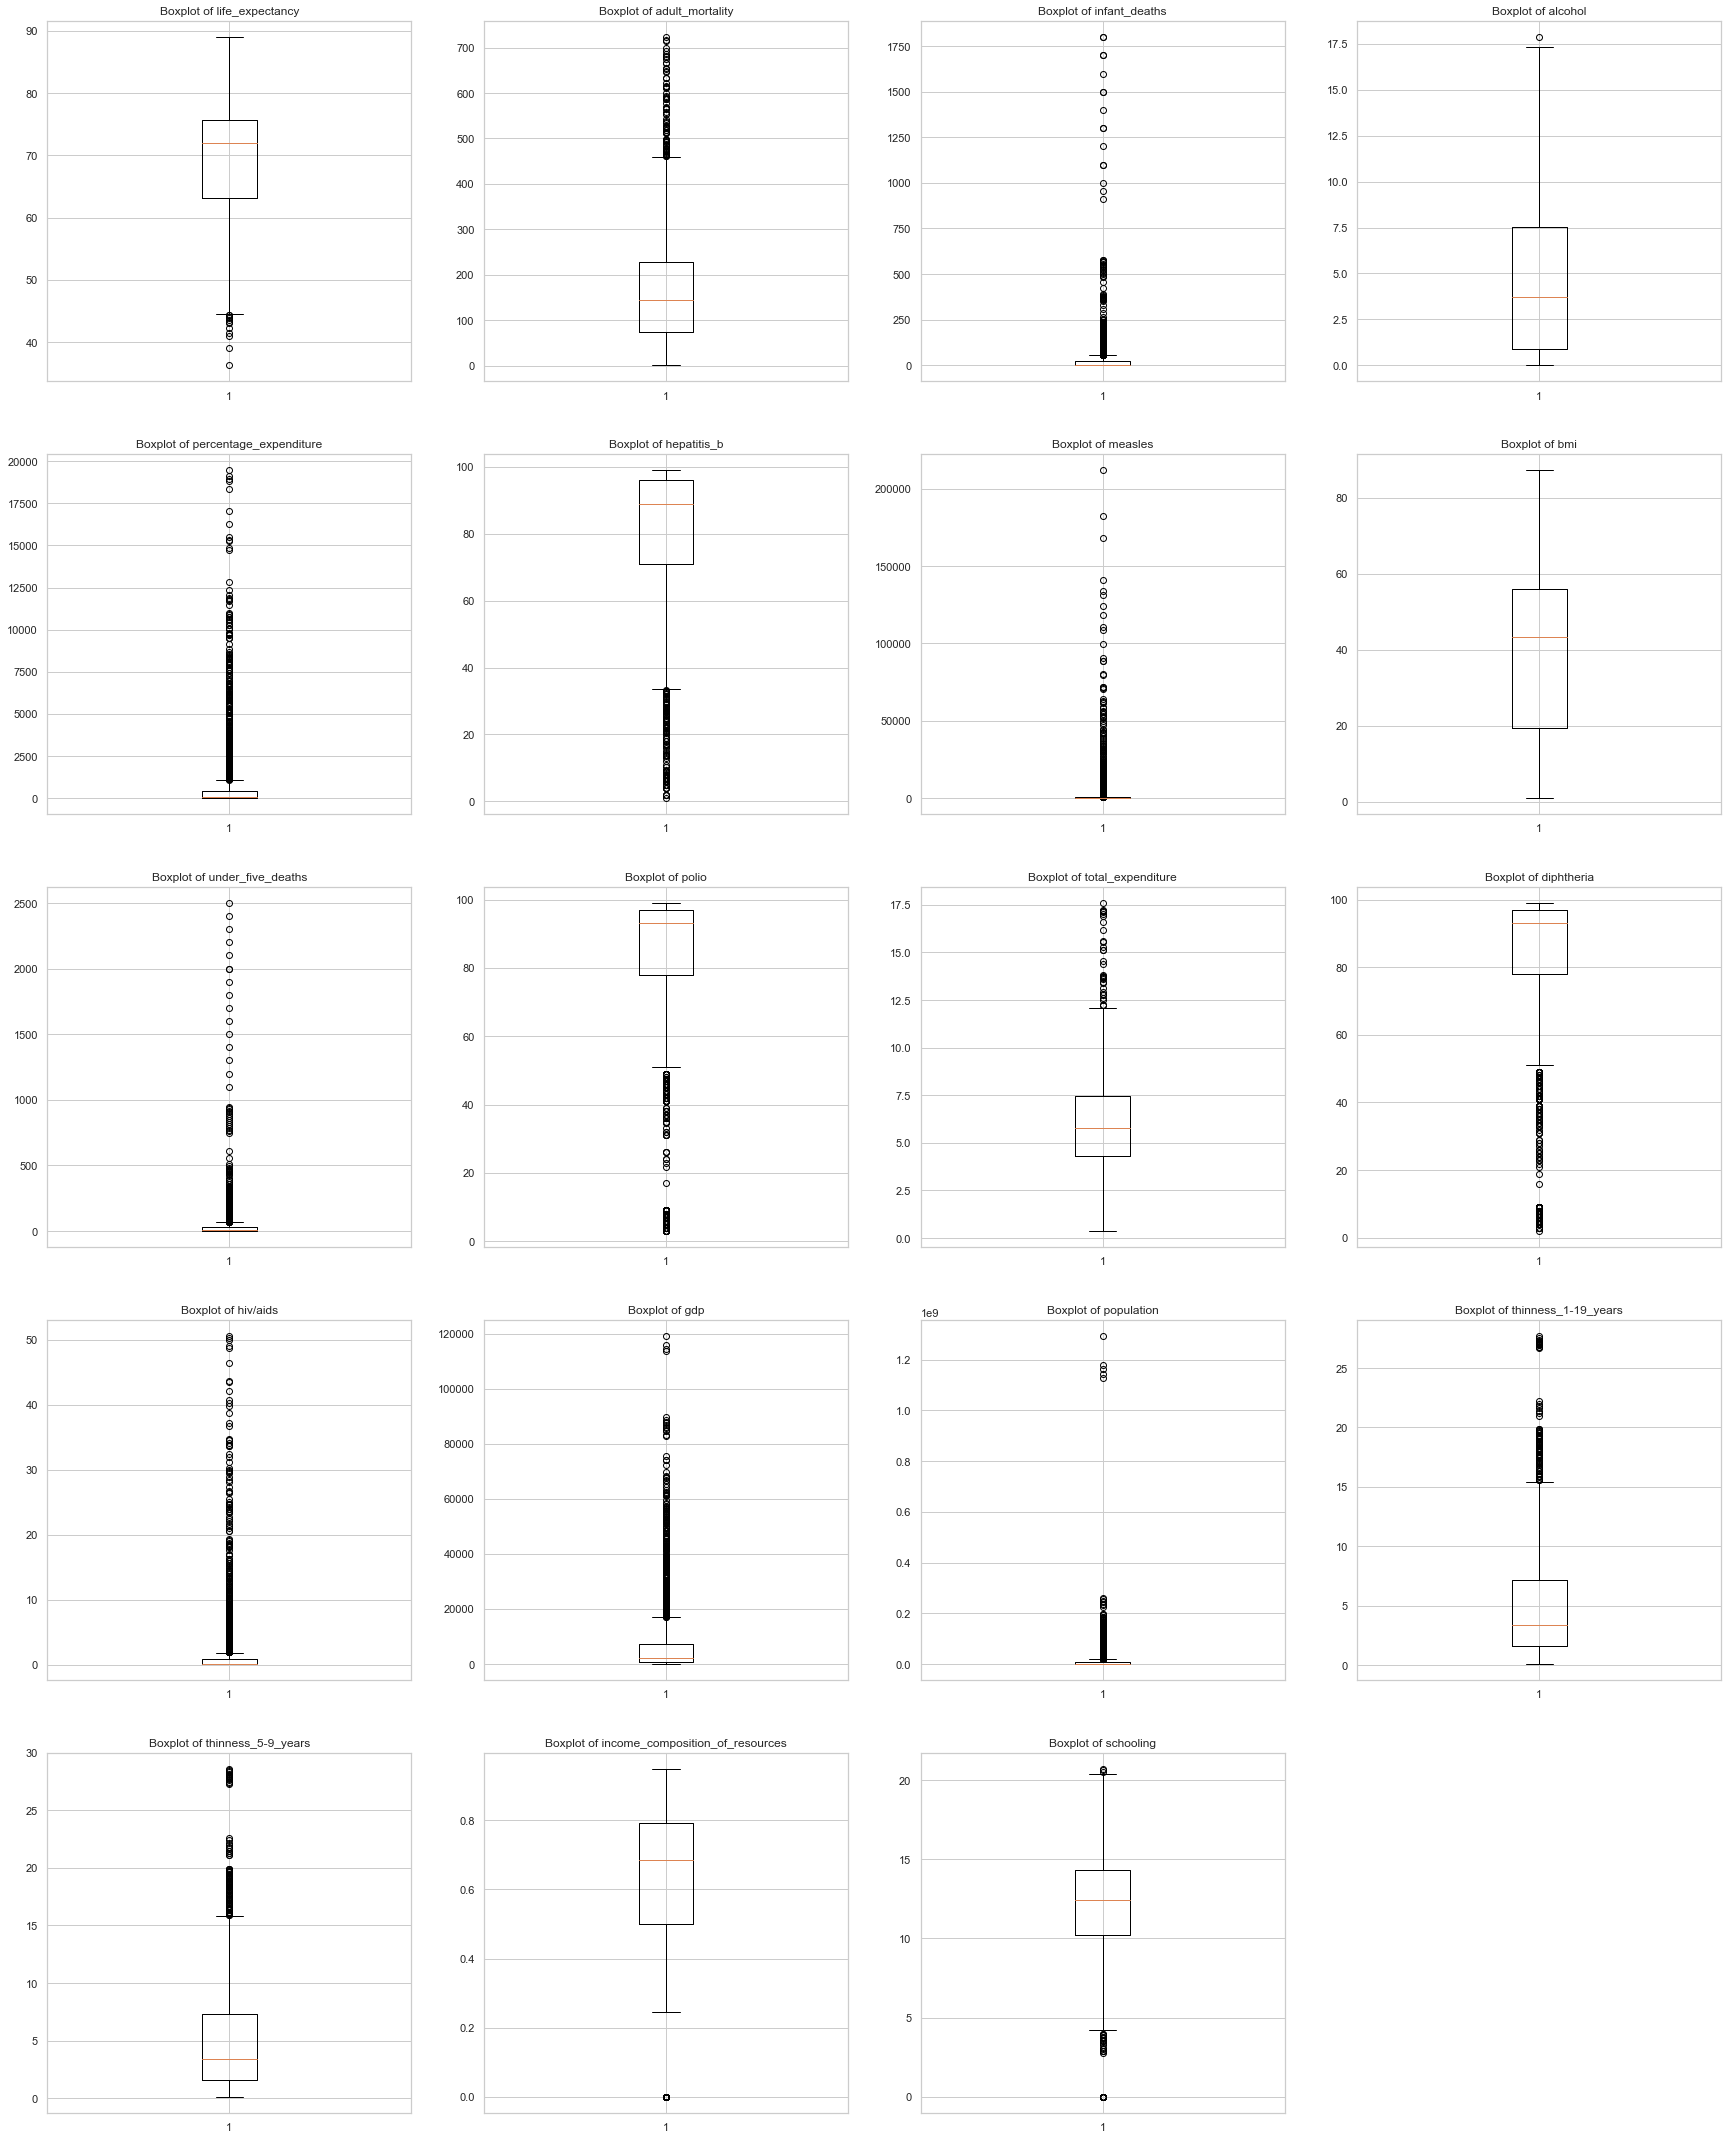

In [12]:
#Visual examination of outliers:
plt.figure(figsize=(30,150))

for i, column in enumerate(fill_list):
    plt.subplot(len(fill_list), 4, i+1)
    plt.boxplot(life_expectancy_df2[column])
    plt.title("Boxplot of {}".format(column))
    
plt.show()

In [13]:
#Detecting outliers using Tukey's method(IQR range)
for column in fill_list:
    q75, q25 = np.percentile(life_expectancy_df2[column], [75 ,25])
    iqr = q75 - q25
    #This method considers all values that are outside the threshold of 1.5 times the IQR as outliers
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers in {}: {}".format(
        column, 
        len((np.where((life_expectancy_df2[column] > max_val) | (life_expectancy_df2[column] < min_val))[0]))))

Number of outliers in life_expectancy: 12
Number of outliers in adult_mortality: 82
Number of outliers in infant_deaths: 315
Number of outliers in alcohol: 1
Number of outliers in percentage_expenditure: 389
Number of outliers in hepatitis_b: 248
Number of outliers in measles: 542
Number of outliers in bmi: 0
Number of outliers in under_five_deaths: 394
Number of outliers in polio: 282
Number of outliers in total_expenditure: 35
Number of outliers in diphtheria: 301
Number of outliers in hiv/aids: 542
Number of outliers in gdp: 349
Number of outliers in population: 365
Number of outliers in thinness_1-19_years: 89
Number of outliers in thinness_5-9_years: 97
Number of outliers in income_composition_of_resources: 130
Number of outliers in schooling: 53


In [14]:
#Using winsorization to deal with outliers
winsorized_list = ['winsorized_life_expectancy',
                   'winsorized_adult_mortality',
                   'winsorized_infant_deaths',
                   'winsorized_alcohol',
                   'winsorized_percentage_expenditure',
                   'winsorized_hepatitis_b',
                   'winsorized_measles',
                   #bmi has no outliers:
                   'bmi',
                   'winsorized_under_five_deaths',
                   'winsorized_total_expenditure',
                   'winsorized_diphtheria',
                   'winsorized_hiv/aids',
                   'winsorized_gdp',
                   'winsorized_population',
                   'winsorized_thinness_1-19_years',
                   'winsorized_thinness_5-9_years',
                   'winsorized_income_composition_of_resources',
                   'winsorized_schooling']

#Apply one or two way winsorization based on boxplots with outliers:
life_expectancy_df2['winsorized_life_expectancy'] = winsorize(life_expectancy_df2['life_expectancy'], (0.05, 0.0))
#plt.boxplot(life_expectancy_df2['winsorized_life_expectancy'])
life_expectancy_df2['winsorized_adult_mortality'] = winsorize(life_expectancy_df2['adult_mortality'], (0.05, 0.05))
life_expectancy_df2['winsorized_infant_deaths'] = winsorize(life_expectancy_df2['infant_deaths'], (0.05, 0.15))
life_expectancy_df2['winsorized_alcohol'] = winsorize(life_expectancy_df2['alcohol'], (0.05, 0.05))
life_expectancy_df2['winsorized_percentage_expenditure'] = winsorize(life_expectancy_df2['percentage_expenditure'], (0.0, 0.15))
life_expectancy_df2['winsorized_hepatitis_b'] = winsorize(life_expectancy_df2['hepatitis_b'], (0.1, 0.0))
life_expectancy_df2['winsorized_measles'] = winsorize(life_expectancy_df2['measles'], (0.0, 0.2))
#skip bmi
life_expectancy_df2['winsorized_under_five_deaths'] = winsorize(life_expectancy_df2['under_five_deaths'], (0.0, 0.15))
life_expectancy_df2['winsorized_total_expenditure'] = winsorize(life_expectancy_df2['total_expenditure'], (0.05, 0.05))
life_expectancy_df2['winsorized_diphtheria'] = winsorize(life_expectancy_df2['diphtheria'], (0.15, 0.05))
life_expectancy_df2['winsorized_hiv/aids'] = winsorize(life_expectancy_df2['hiv/aids'], (0.0, 0.2))
life_expectancy_df2['winsorized_gdp'] = winsorize(life_expectancy_df2['gdp'], (0.0, 0.15))
life_expectancy_df2['winsorized_population'] = winsorize(life_expectancy_df2['population'], (0.0, 0.15))
life_expectancy_df2['winsorized_thinness_1-19_years'] = winsorize(life_expectancy_df2['thinness_1-19_years'], (0.05, 0.05))
life_expectancy_df2['winsorized_thinness_5-9_years'] = winsorize(life_expectancy_df2['thinness_5-9_years'], (0.05, 0.05))
life_expectancy_df2['winsorized_income_composition_of_resources'] = winsorize(life_expectancy_df2['income_composition_of_resources'], (0.05, 0.05))
life_expectancy_df2['winsorized_schooling'] = winsorize(life_expectancy_df2['schooling'], (0.05, 0.05))

#Check on columns/winsorization:
life_expectancy_df2.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling',
       'winsorized_life_expectancy', 'winsorized_adult_mortality',
       'winsorized_infant_deaths', 'winsorized_alcohol',
       'winsorized_percentage_expenditure', 'winsorized_hepatitis_b',
       'winsorized_measles', 'winsorized_under_five_deaths',
       'winsorized_total_expenditure', 'winsorized_diphtheria',
       'winsorized_hiv/aids', 'winsorized_gdp', 'winsorized_population',
       'winsorized_thinness_1-19_years', 'winsorized_thinness_5-9_years',
       'winsorized_income_composition_of_resources', 'winsorized_schooling'],
      dtype='object')

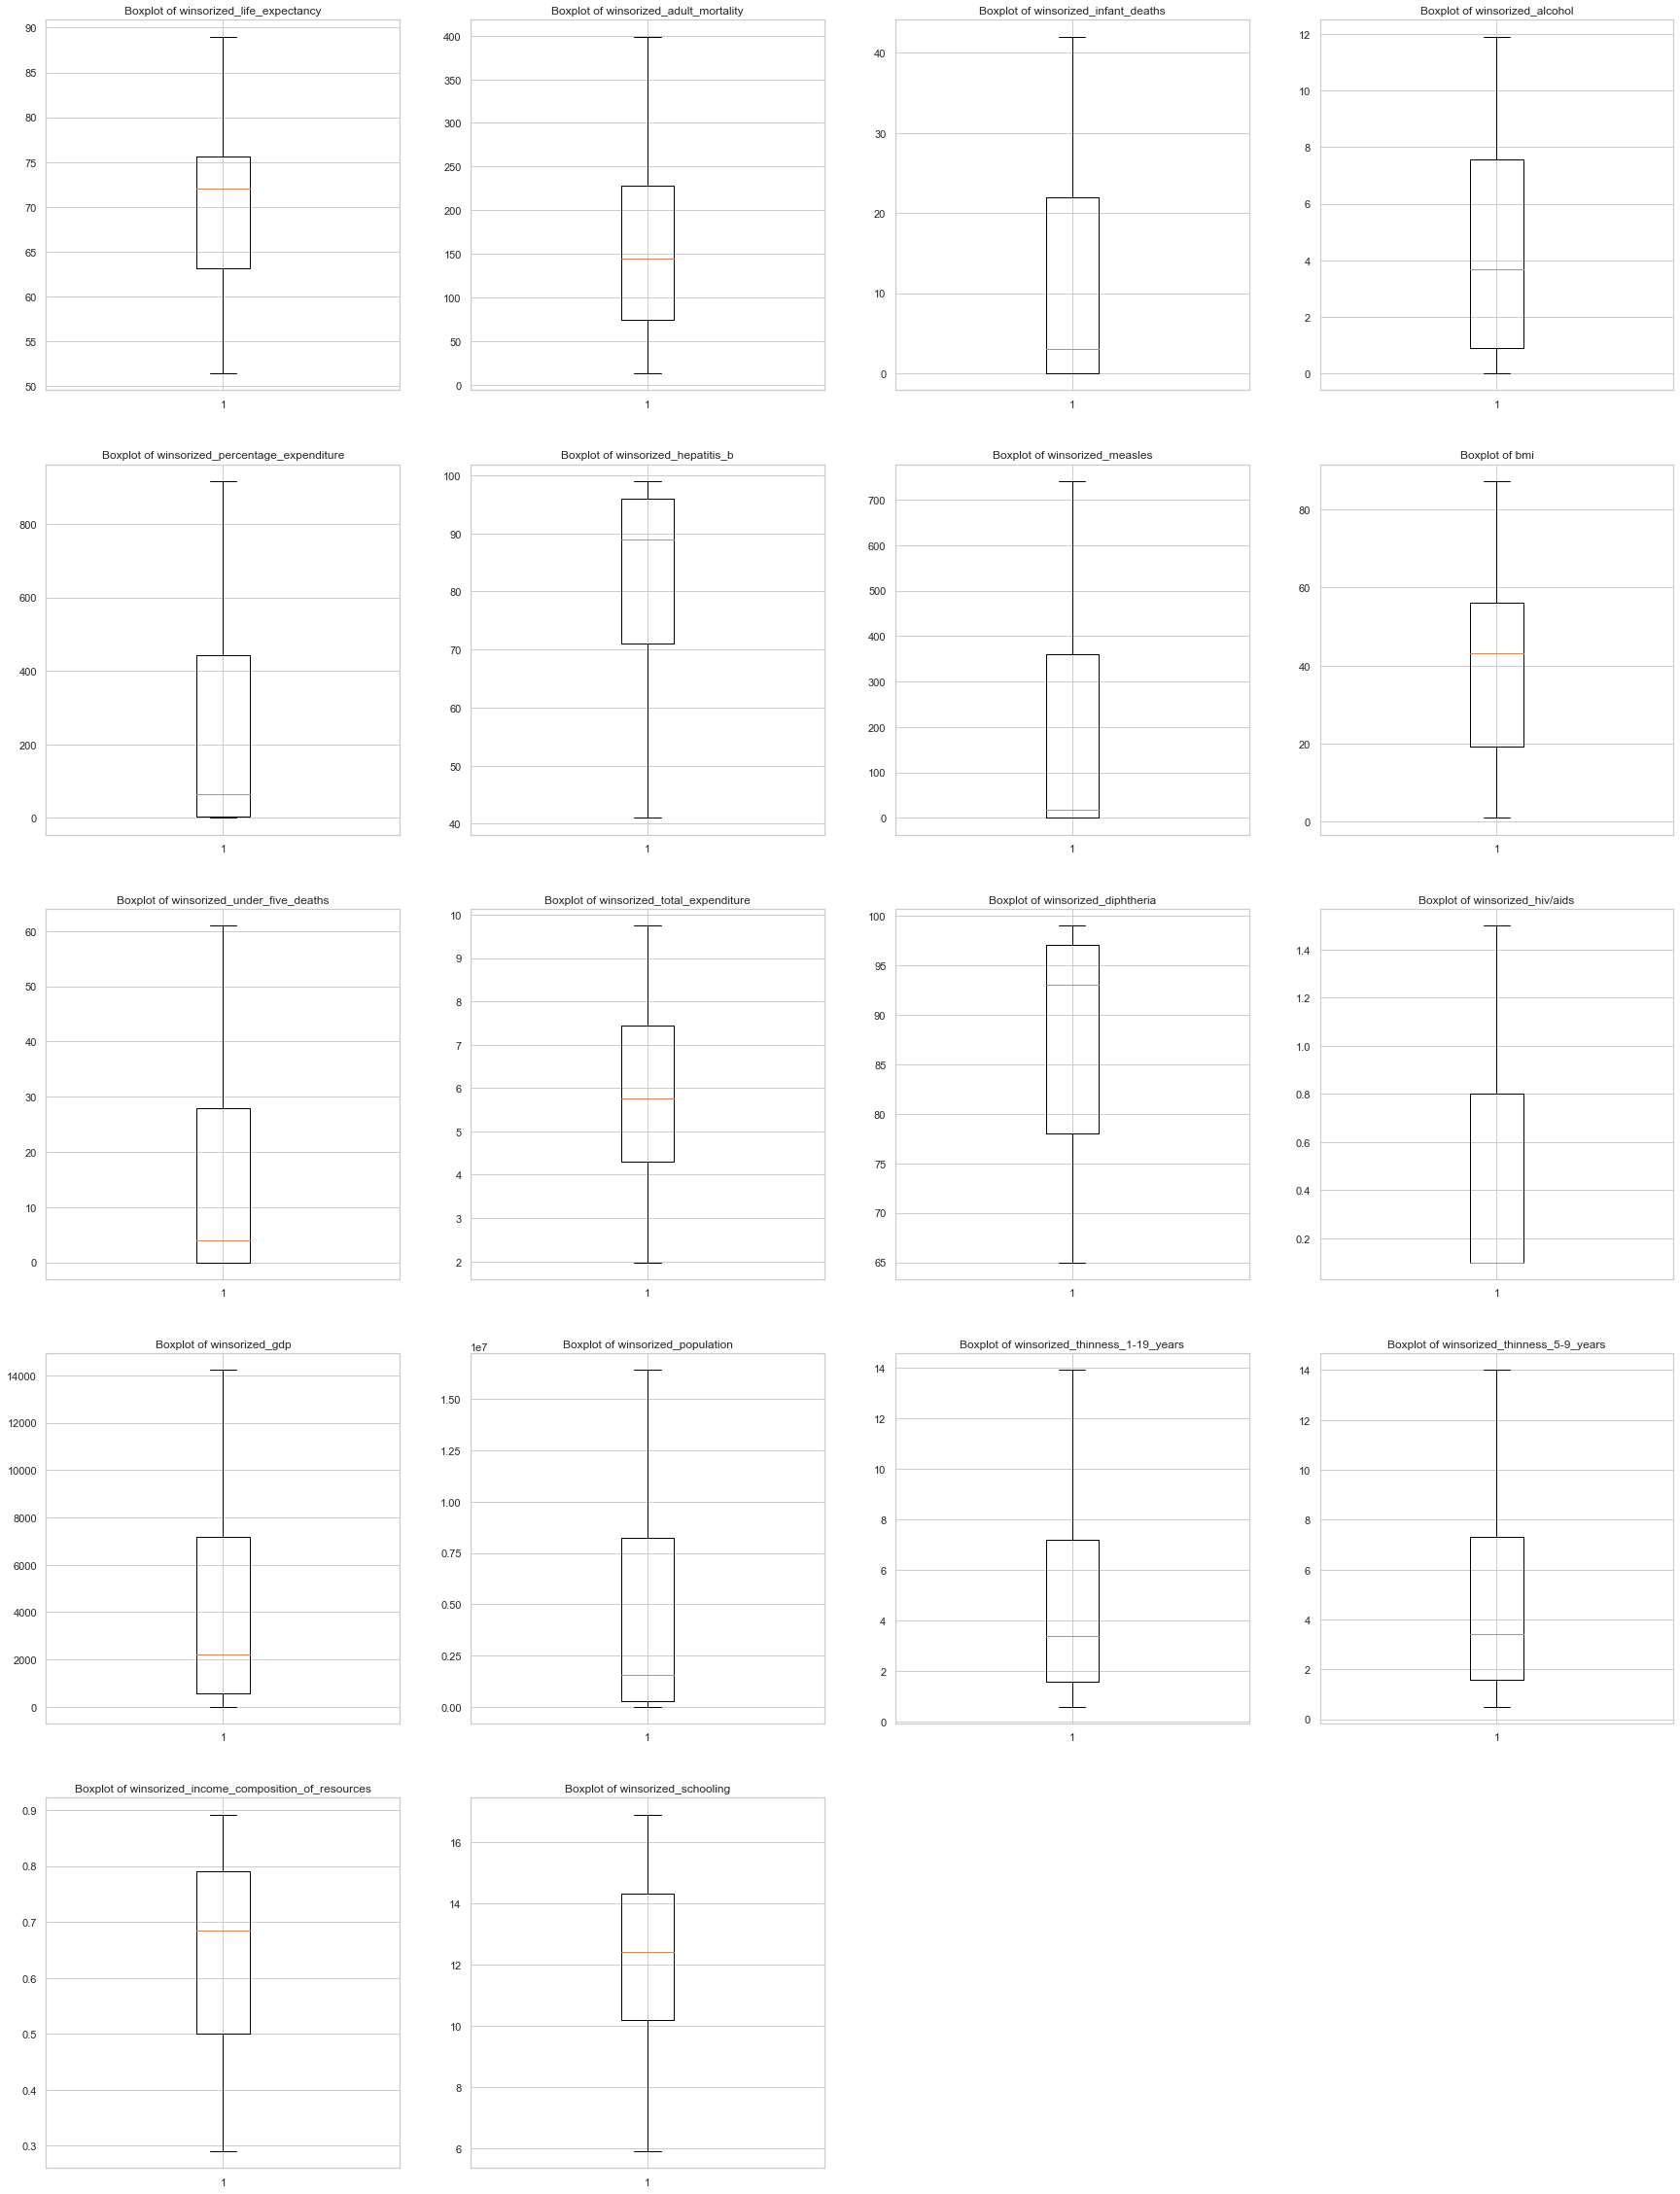

In [15]:
#Visual examination of outliers (after winsorization):
plt.figure(figsize=(30,150))

for i, column in enumerate(winsorized_list):
    plt.subplot(len(winsorized_list), 4, i+1)
    plt.boxplot(life_expectancy_df2[column])
    plt.title("Boxplot of {}".format(column))
    
plt.show()

In [16]:
#Detecting outliers using Tukey's method(IQR range)
for column in winsorized_list:
    q75, q25 = np.percentile(life_expectancy_df2[column], [75 ,25])
    iqr = q75 - q25
    #This method considers all values that are outside the threshold of 1.5 times the IQR as outliers
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers in {}: {}".format(
        column, 
        len((np.where((life_expectancy_df2[column] > max_val) | (life_expectancy_df2[column] < min_val))[0]))))

Number of outliers in winsorized_life_expectancy: 0
Number of outliers in winsorized_adult_mortality: 0
Number of outliers in winsorized_infant_deaths: 0
Number of outliers in winsorized_alcohol: 0
Number of outliers in winsorized_percentage_expenditure: 0
Number of outliers in winsorized_hepatitis_b: 0
Number of outliers in winsorized_measles: 0
Number of outliers in bmi: 0
Number of outliers in winsorized_under_five_deaths: 0
Number of outliers in winsorized_total_expenditure: 0
Number of outliers in winsorized_diphtheria: 0
Number of outliers in winsorized_hiv/aids: 0
Number of outliers in winsorized_gdp: 0
Number of outliers in winsorized_population: 0
Number of outliers in winsorized_thinness_1-19_years: 0
Number of outliers in winsorized_thinness_5-9_years: 0
Number of outliers in winsorized_income_composition_of_resources: 0
Number of outliers in winsorized_schooling: 0


Based on the boxplots and Tukey's method for outliers, there are no remaining outliers after winsorization.

## Exploring the Data

#### Univariate and Multivariate Analysis

In [17]:
life_expectancy_df2.describe()

year  life_expectancy  adult_mortality  infant_deaths  \
count  2938.000000      2938.000000      2938.000000    2938.000000   
mean   2007.518720        69.214874       164.744554      30.303948   
std       4.613841         9.510819       124.226596     117.926501   
min    2000.000000        36.300000         1.000000       0.000000   
25%    2004.000000        63.100000        74.000000       0.000000   
50%    2008.000000        72.000000       144.000000       3.000000   
75%    2012.000000        75.600000       228.000000      22.000000   
max    2015.000000        89.000000       723.000000    1800.000000   

           alcohol  percentage_expenditure  hepatitis_b        measles  \
count  2938.000000             2938.000000  2938.000000    2938.000000   
mean      4.548919              738.251295    78.536419    2419.592240   
std       3.994854             1987.914858    25.177963   11467.272489   
min       0.010000                0.000000     1.000000       0.000000   
25%       0.902500                4.685343    71.000000       0.000000   
50%       3.697500               64.912906    89.000000      17.000000   
75%       7.550000              441.534144    96.000000     360.250000   
max      17.870000            19479.911610    99.000000  212183.000000   

              bmi  under_five_deaths  ...  winsorized_under_five_deaths  \
count  2938.00000        2938.000000  ...                   2938.000000   
mean     38.29869          42.035739  ...                     16.695371   
std      19.99140         160.445548  ...                     22.638913   
min       1.00000           0.000000  ...                      0.000000   
25%      19.32500           0.000000  ...                      0.000000   
50%      43.25000           4.000000  ...                      4.000000   
75%      56.10000          28.000000  ...                     28.000000   
max      87.30000        2500.000000  ...                     61.000000   

       winsorized_total_expenditure  winsorized_diphtheria  \
count                   2938.000000             2938.00000   
mean                       5.864505               87.00423   
std                        2.151291               12.12187   
min                        1.980000               65.00000   
25%                        4.312500               78.00000   
50%                        5.760000               93.00000   
75%                        7.440000               97.00000   
max                        9.750000               99.00000   

       winsorized_hiv/aids  winsorized_gdp  winsorized_population  \
count          2938.000000     2938.000000           2.938000e+03   
mean              0.469197     4564.157393           4.902386e+06   
std               0.569172     5087.554822           6.049273e+06   
min               0.100000        1.681350           3.400000e+01   
25%               0.100000      553.618620           2.536025e+05   
50%               0.100000     2192.681084           1.576319e+06   
75%               0.800000     7183.381694           8.215738e+06   
max               1.500000    14223.865760           1.642558e+07   

       winsorized_thinness_1-19_years  winsorized_thinness_5-9_years  \
count                     2938.000000                    2938.000000   
mean                         4.702979                       4.716613   
std                          3.806472                       3.840343   
min                          0.600000                       0.500000   
25%                          1.600000                       1.600000   
50%                          3.400000                       3.400000   
75%                          7.200000                       7.300000   
max                         13.900000                      14.000000   

       winsorized_income_composition_of_resources  winsorized_schooling  
count                                 2938.000000           2938.000000  
mean                                     0.646445    

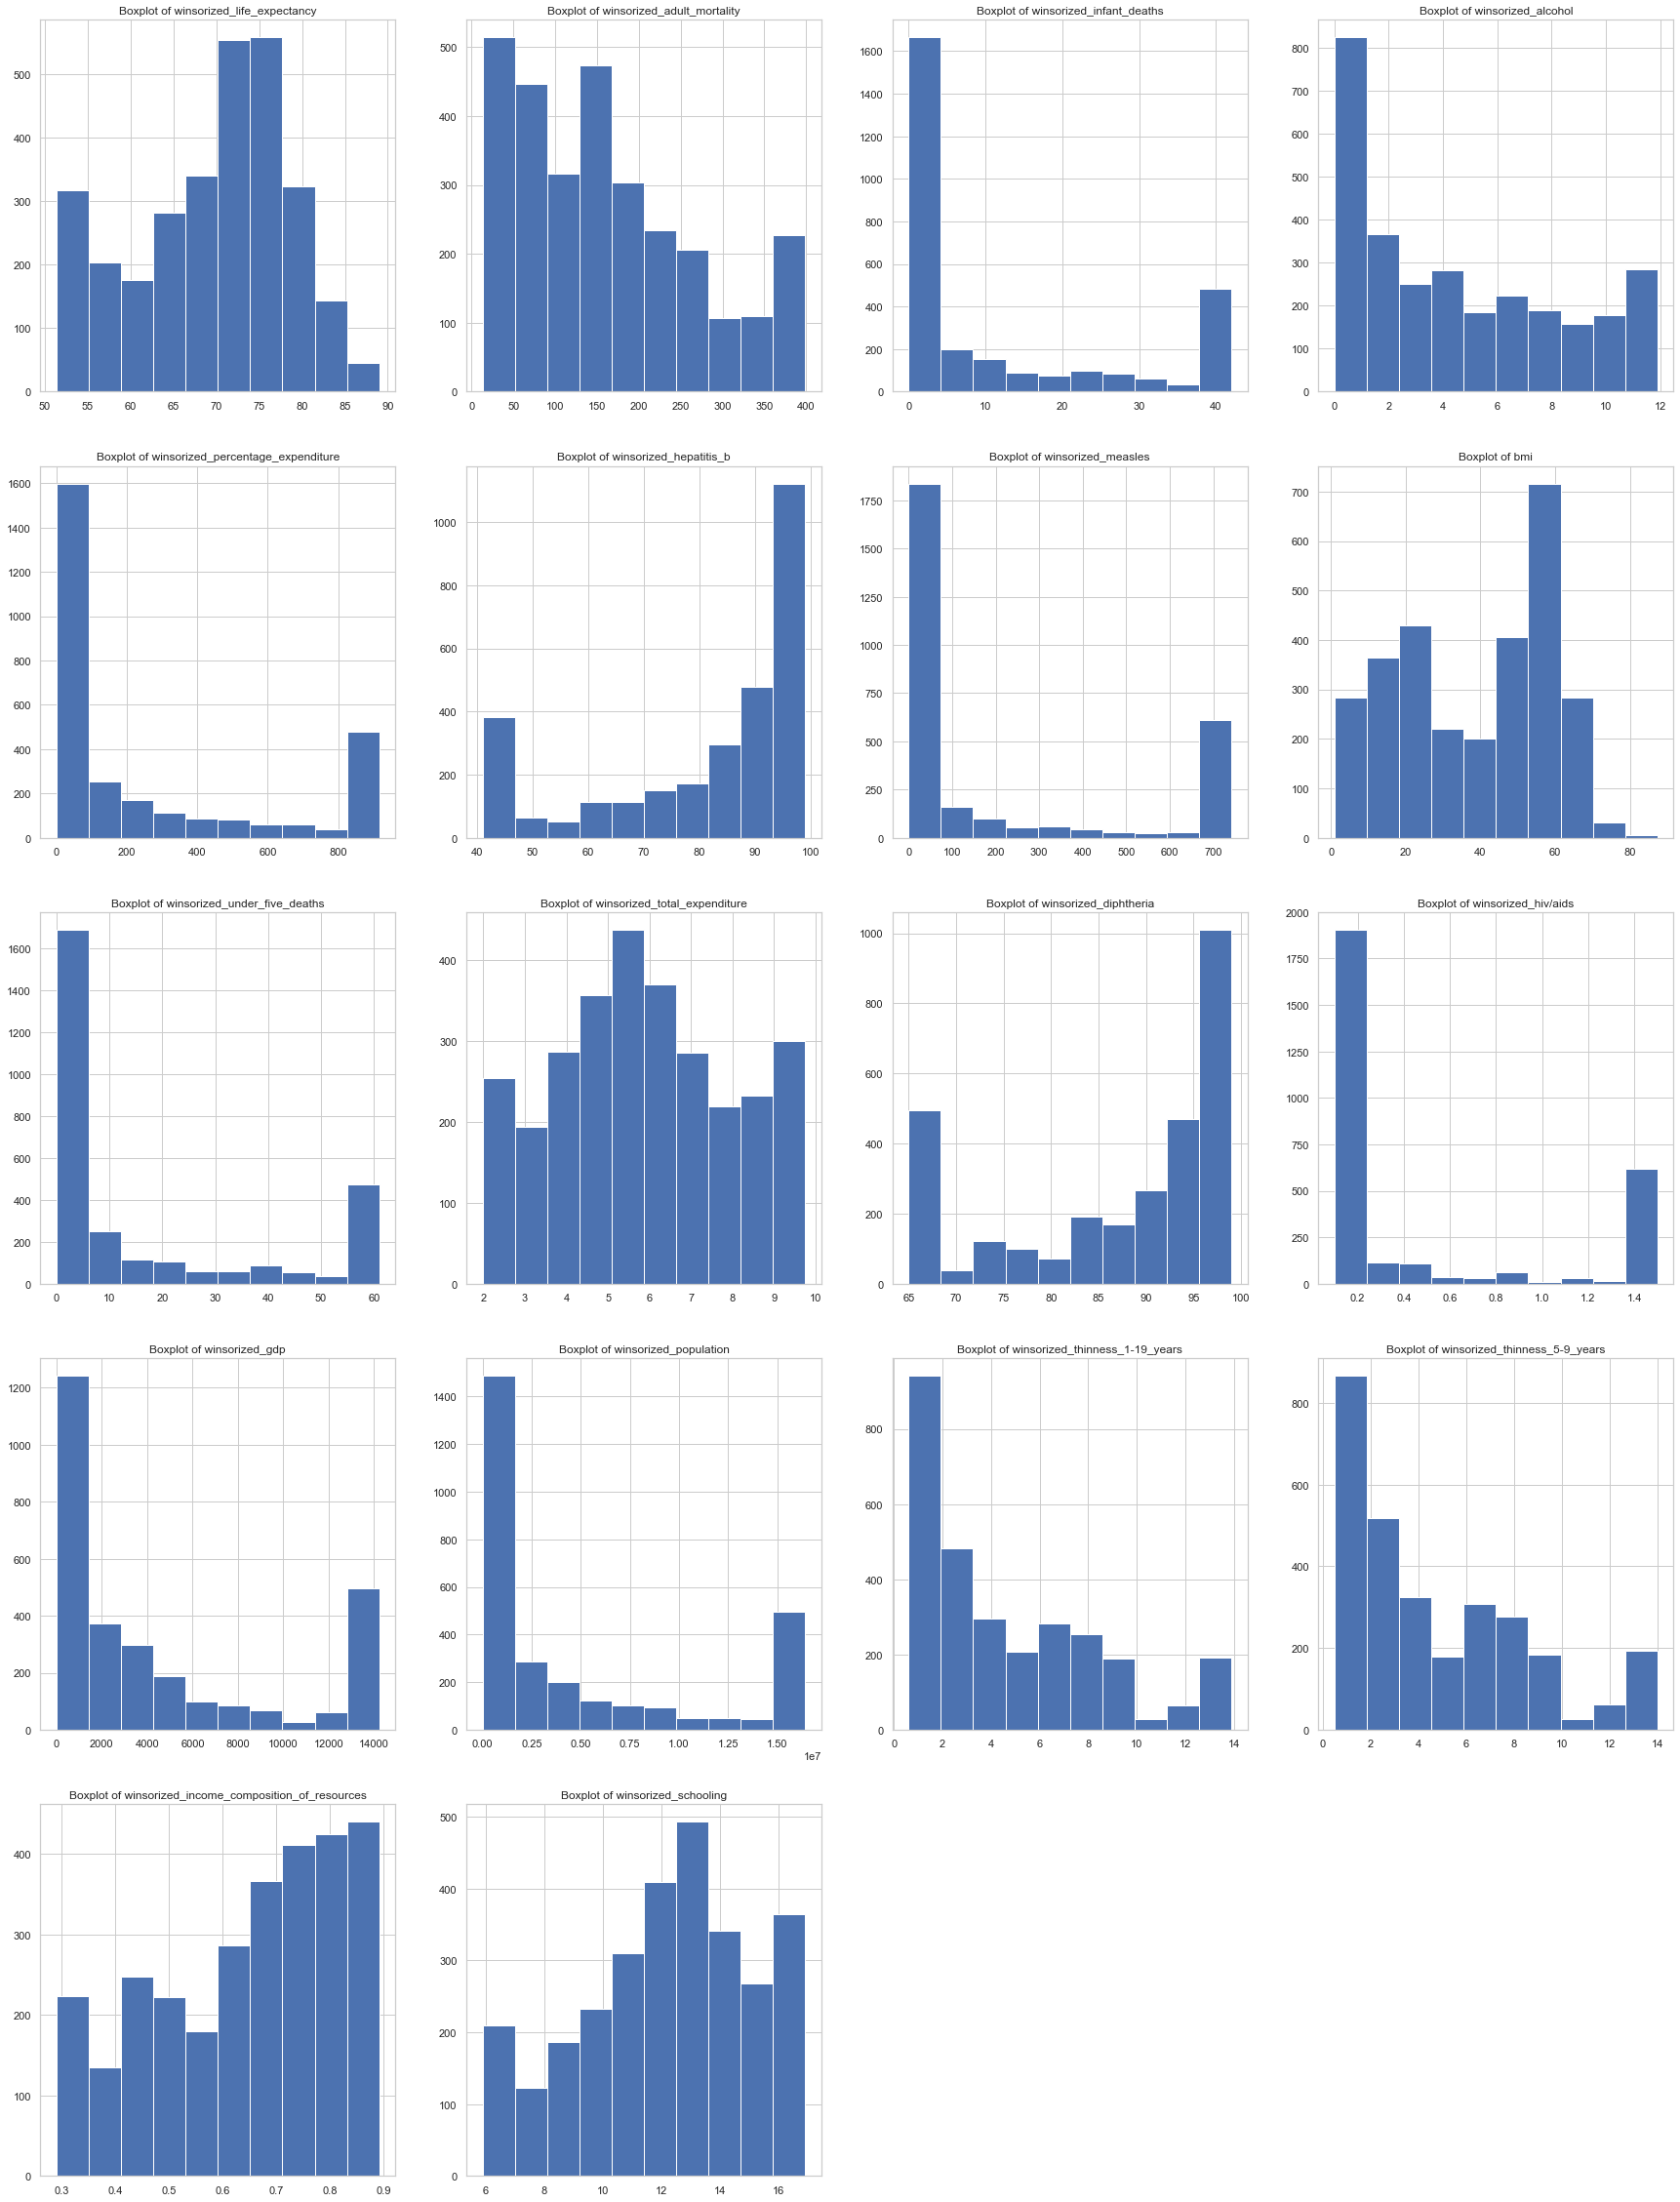

In [18]:
#Evaluating distributions for each variable
plt.figure(figsize=(30,150))

for i, column in enumerate(winsorized_list):
    plt.subplot(len(winsorized_list), 4, i+1)
    plt.hist(life_expectancy_df2[column])
    plt.title("Boxplot of {}".format(column))
    
plt.show()

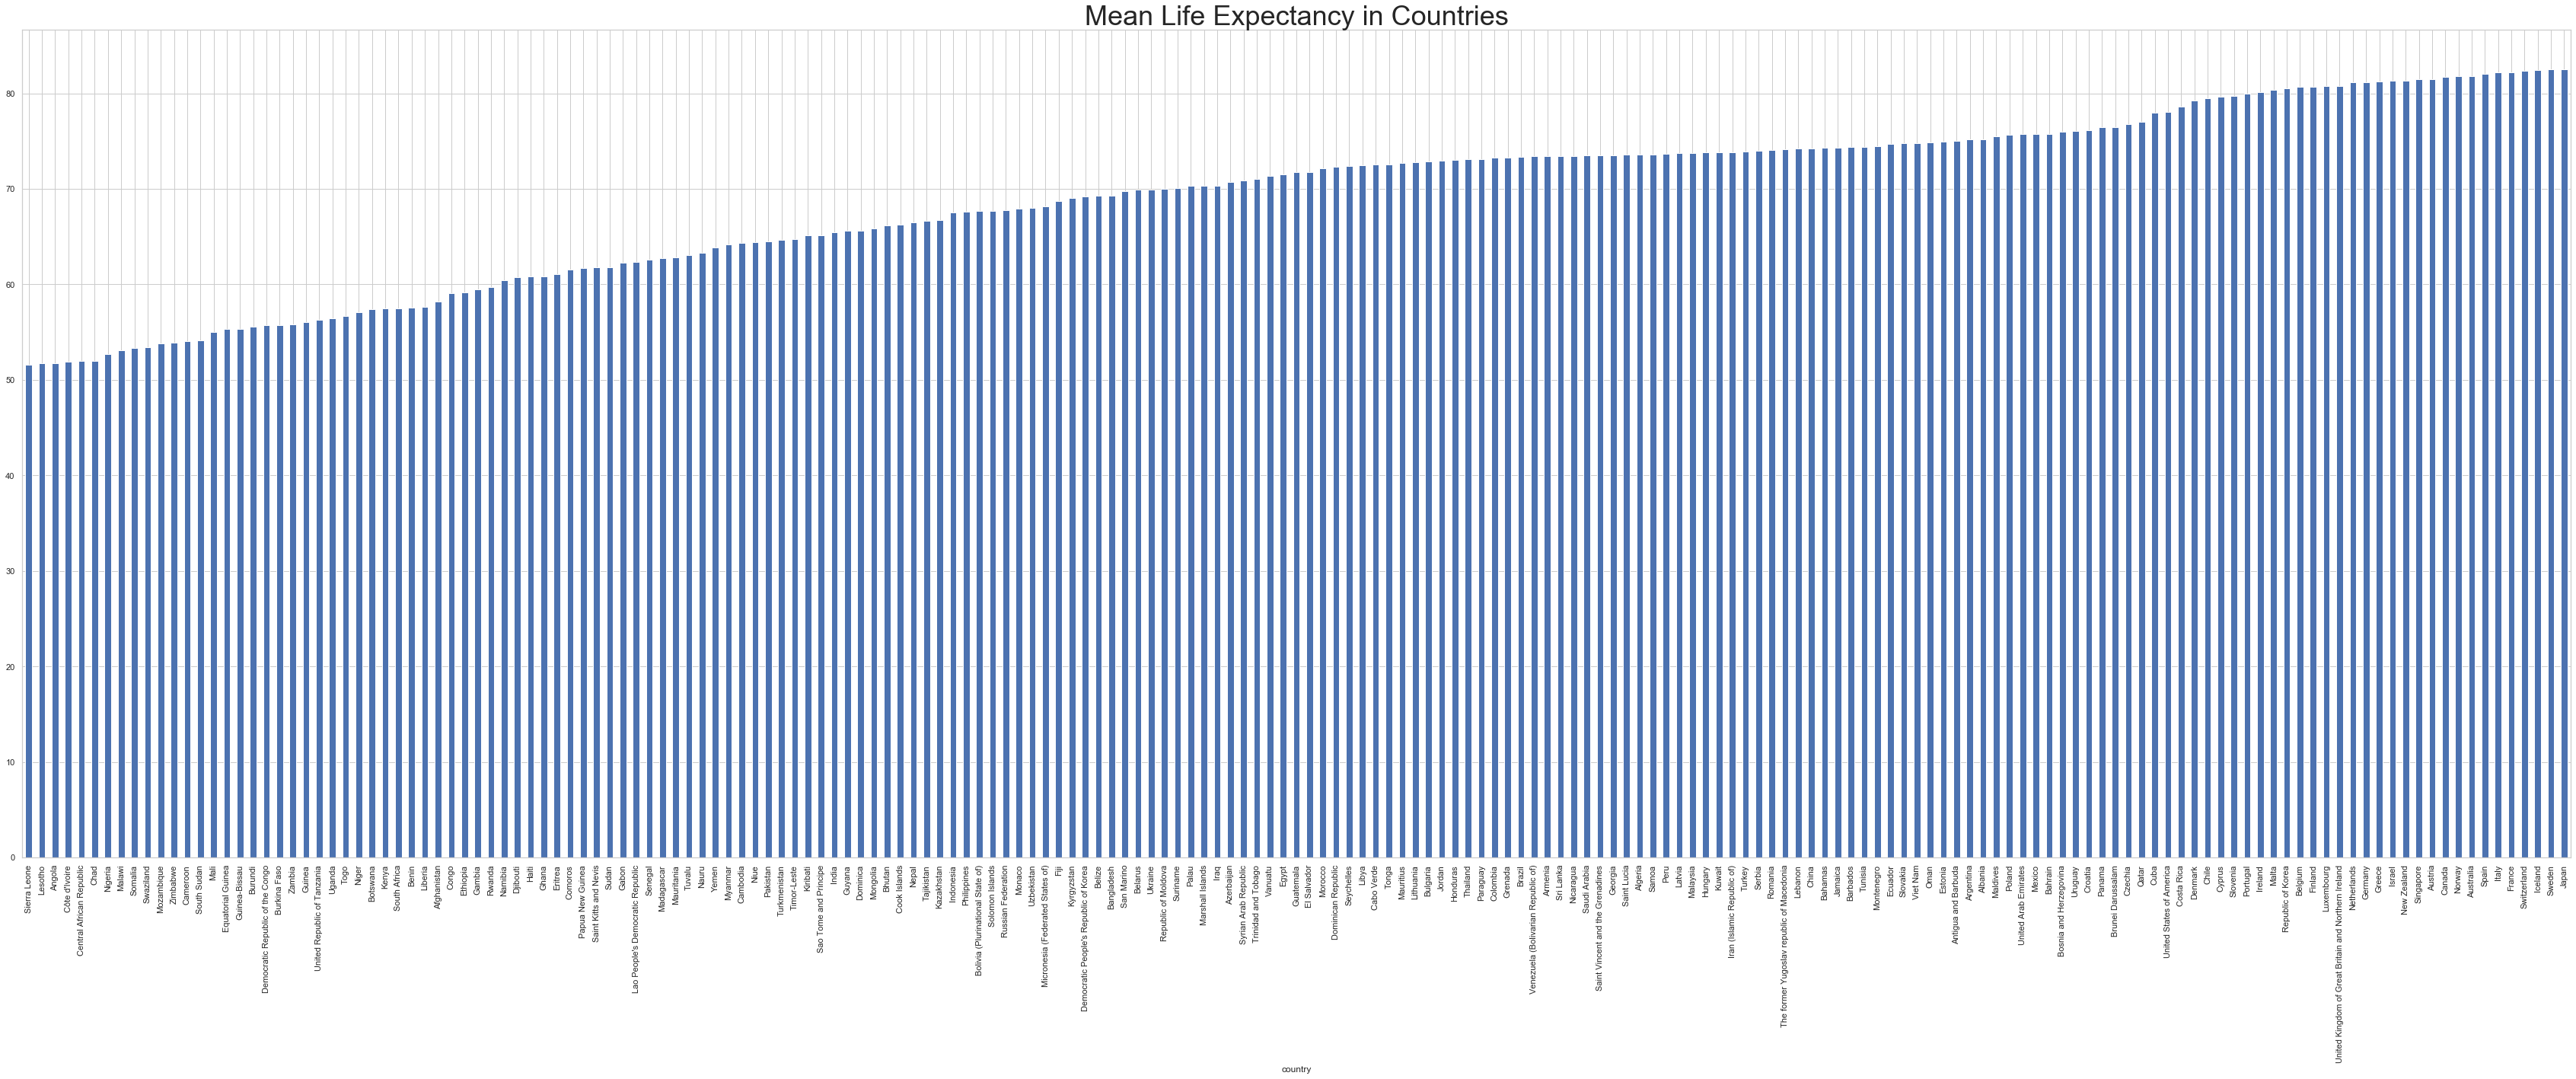

In [19]:
#Evaluating Mean Life Expectancy in Countries
plt.figure(figsize=(60, 20))
country_plot = life_expectancy_df2.groupby('country')['winsorized_life_expectancy'].mean().sort_values()
country_plot.plot(kind='bar')
plt.title('Mean Life Expectancy in Countries', fontsize=36)
plt.show()

In [20]:
life_expectancy_df2.groupby('country')['winsorized_life_expectancy'].mean().sort_values()

country
Sierra Leone                                            51.56250
Lesotho                                                 51.73750
Angola                                                  51.76875
Côte d'Ivoire                                           51.88750
Central African Republic                                51.98125
Chad                                                    52.01875
Nigeria                                                 52.73125
Malawi                                                  53.06250
Somalia                                                 53.35000
Swaziland                                               53.45000
Mozambique                                              53.80000
Zimbabwe                                                53.88125
Cameroon                                                54.01875
South Sudan                                             54.14375
Mali                                                    55.05000
Equatorial Guinea

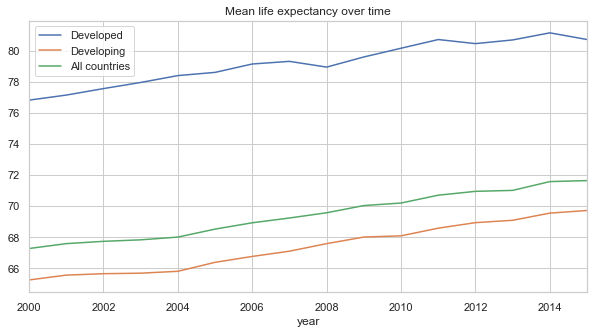

In [21]:
#Evaluaitng mean life expectancy over time
plt.figure(figsize=(10,5))

year_plot = life_expectancy_df2.loc[life_expectancy_df2.status == 'Developed'].groupby('year')['winsorized_life_expectancy'].mean()
year_plot2 = life_expectancy_df2.loc[life_expectancy_df2.status == 'Developing'].groupby('year')['winsorized_life_expectancy'].mean()
year_plot3 = life_expectancy_df2.groupby('year')['winsorized_life_expectancy'].mean()
year_plot.plot(kind='line', label = 'Developed')
year_plot2.plot(kind='line', label = 'Developing')
year_plot3.plot(kind='line', label = 'All countries')
plt.title('Mean life expectancy over time')

plt.legend()
plt.show()

In [22]:
#Comparing statistics by country status
life_expectancy_df2.groupby('status').mean()

year  life_expectancy  adult_mortality  infant_deaths  \
status                                                                     
Developed   2007.500000        79.197852        79.685547       1.494141   
Developing  2007.522671        67.107997       182.696002      36.384171   

             alcohol  percentage_expenditure  hepatitis_b      measles  \
status                                                                   
Developed   9.634141             2703.600380    83.806185   499.005859   
Developing  3.475699              323.470285    77.424251  2824.926216   

                  bmi  under_five_deaths  ...  winsorized_under_five_deaths  \
status                                    ...                                 
Developed   51.803906           1.810547  ...                      1.810547   
Developing  35.448454          50.525144  ...                     19.836768   

            winsorized_total_expenditure  winsorized_diphtheria  \
status                                                            
Developed                       7.287187              94.570312   
Developing                      5.564252              85.407431   

            winsorized_hiv/aids  winsorized_gdp  winsorized_population  \
status                                                                   
Developed              0.100000     9526.953875           4.490581e+06   
Developing             0.547115     3516.774129           4.989296e+06   

            winsorized_thinness_1-19_years  winsorized_thinness_5-9_years  \
status                                                                      
Developed                         1.344141                       1.315039   
Developing                        5.411852                       5.434505   

            winsorized_income_composition_of_resources  winsorized_schooling  
status                                                                        
Developed                                     0.842822             15.347648  
Developing                                    0.605000             11.431930  

[2 rows x 37 columns]

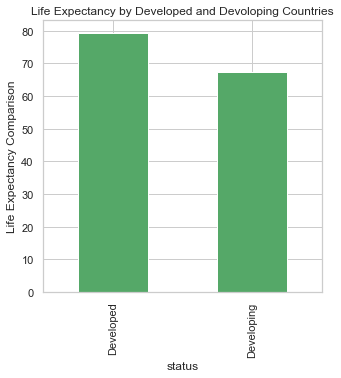

status
Developed     79.197852
Developing    67.337923
Name: winsorized_life_expectancy, dtype: float64

In [23]:
#Plot developed and developing countries (group by 'status')
plt.figure(figsize=(5, 5))
status_plot = life_expectancy_df2.groupby('status')['winsorized_life_expectancy'].mean()
status_plot.plot(kind='bar', color = 'g')
plt.title('Life Expectancy by Developed and Devoloping Countries')
plt.ylabel('Life Expectancy Comparison')

plt.show()

life_expectancy_df2.groupby('status')['winsorized_life_expectancy'].mean()

In [24]:
ttest_ind(life_expectancy_df2.loc[life_expectancy_df2['status'] == 'Developed', 'winsorized_life_expectancy'],
          life_expectancy_df2.loc[life_expectancy_df2['status'] == 'Developing', 'winsorized_life_expectancy'])

Ttest_indResult(statistic=30.87605491974652, pvalue=1.5938490071063733e-181)

There is a significant difference in the mean life expectancy in developed countries (mean = 79.2 years) verus developing countries (mean = 67.34 years).

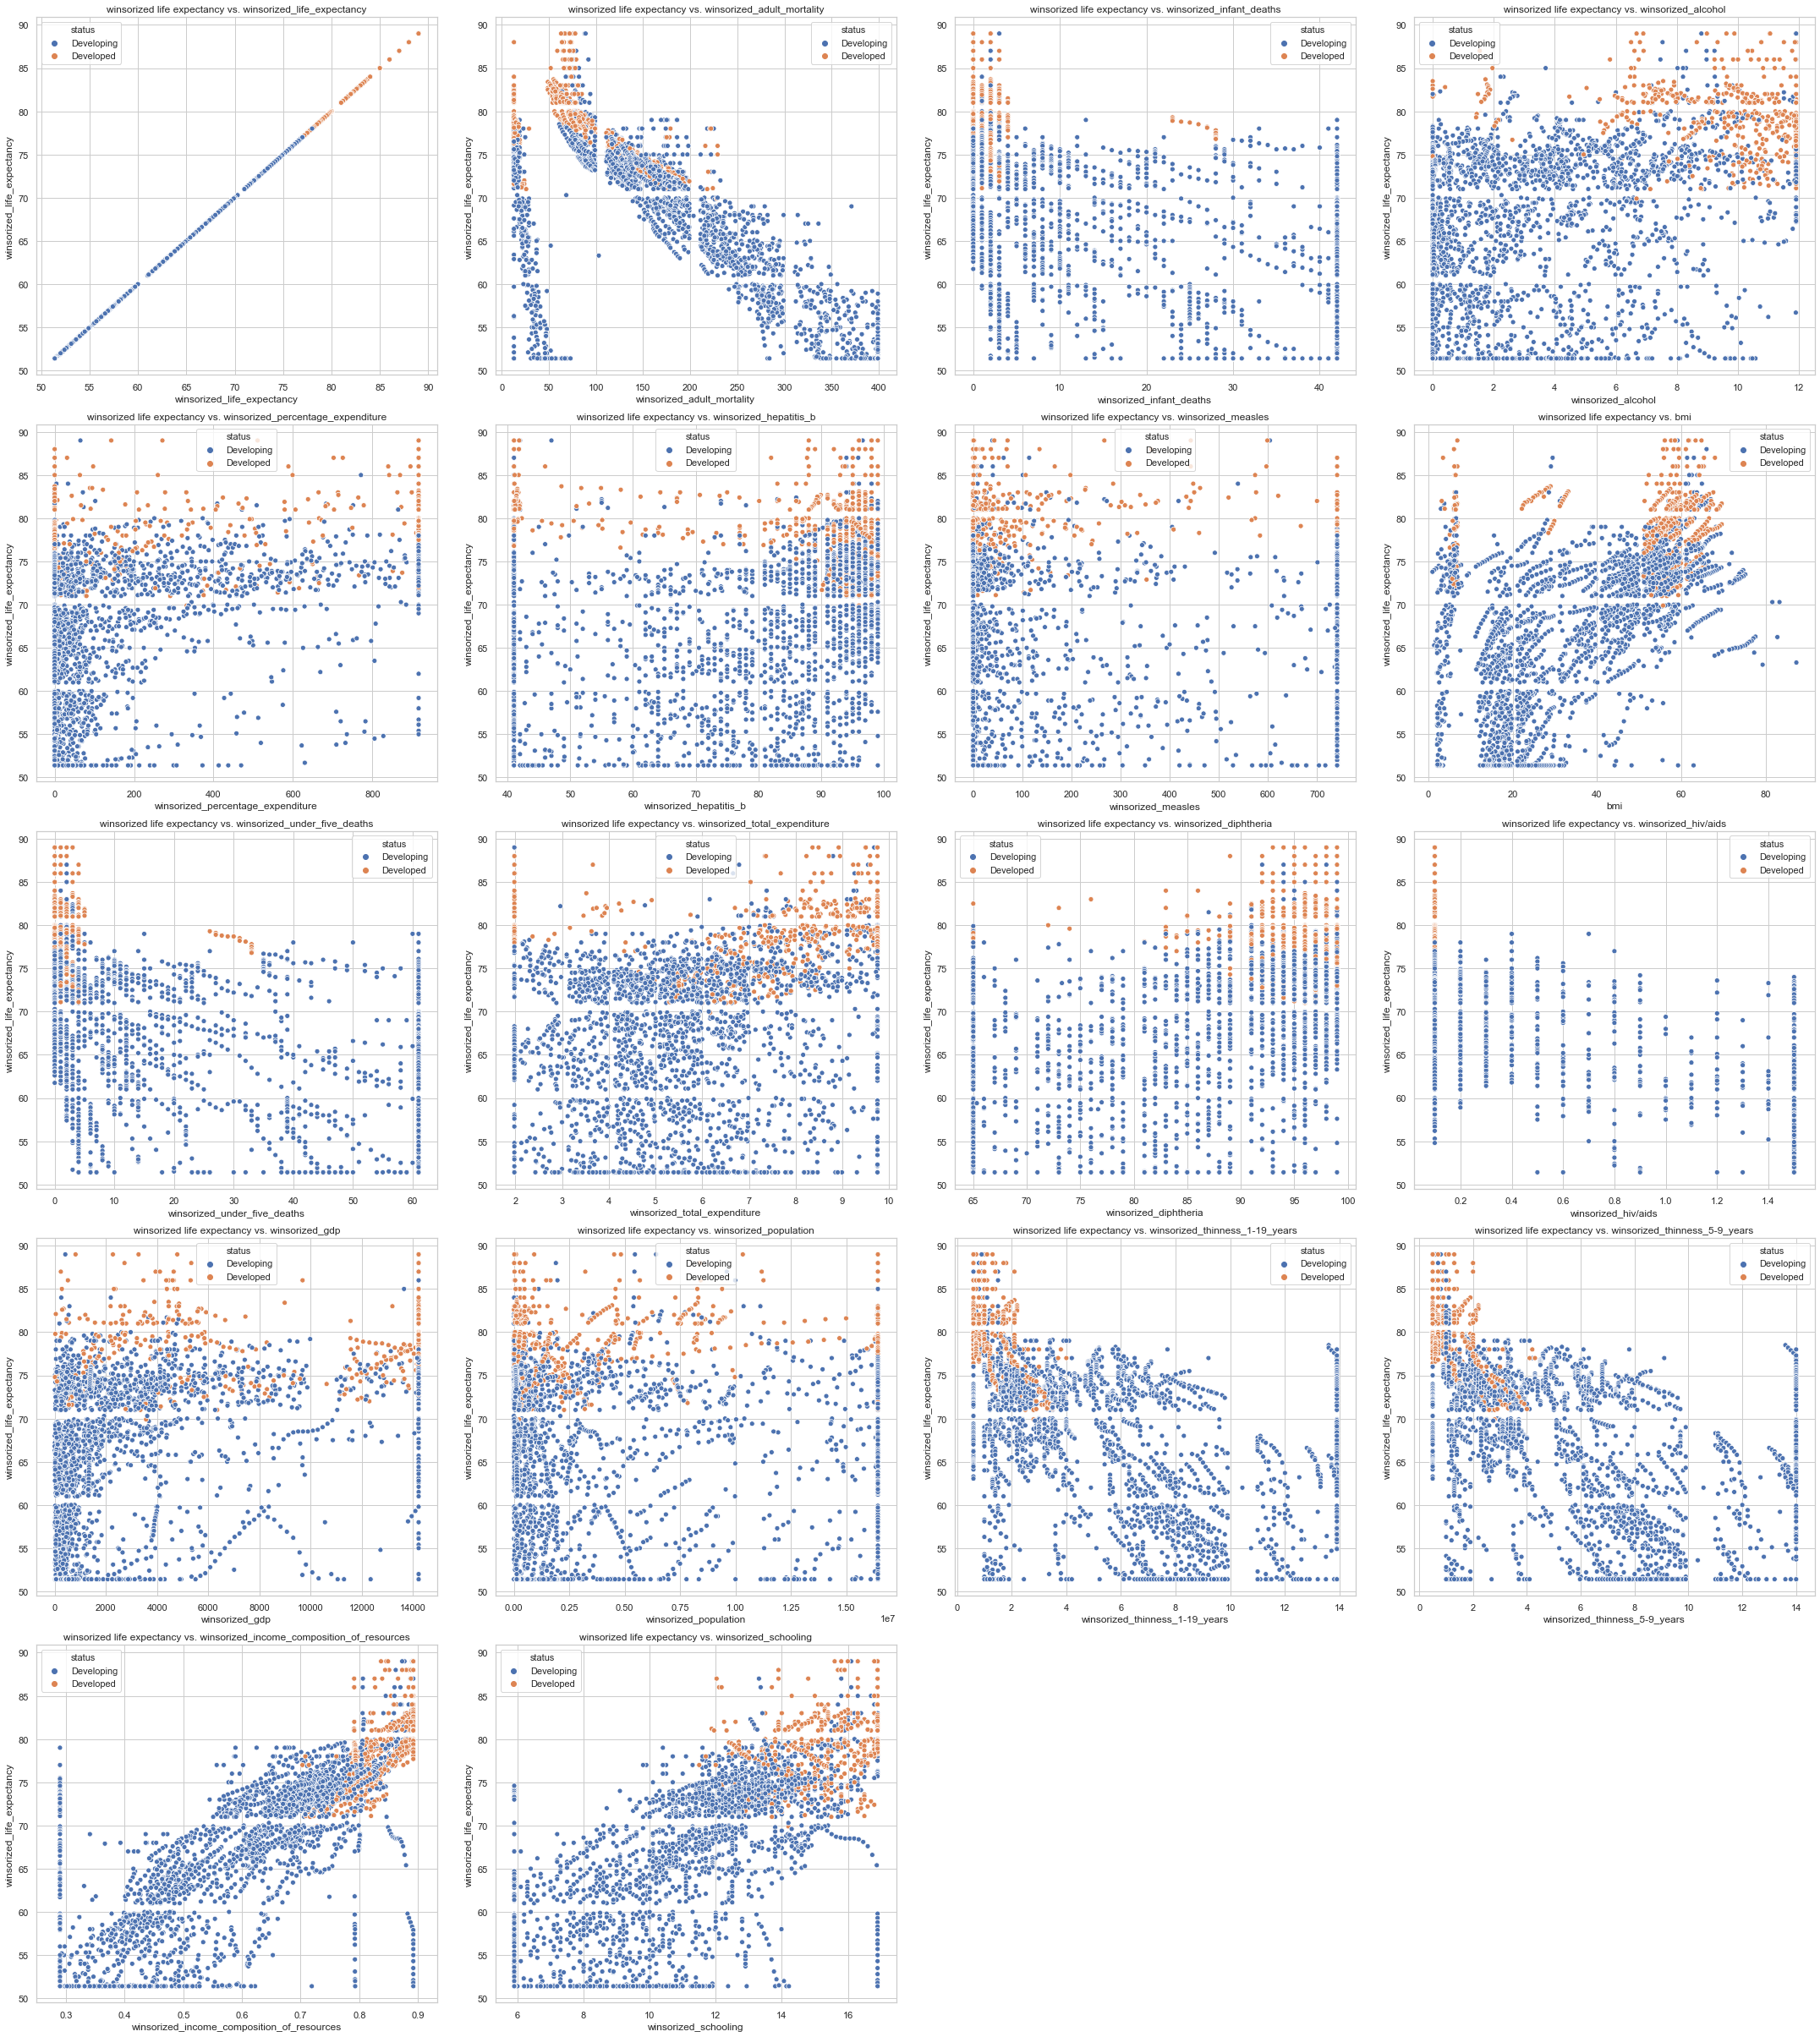

In [25]:
#Evaluating relationships between variables:
fig = plt.figure(figsize=(30,120))

for i, column in enumerate(winsorized_list):
    
    plt.subplot(len(winsorized_list), 4, i+1)
    sns.scatterplot(x=column,
                   y='winsorized_life_expectancy',
                   hue='status',
                   data=life_expectancy_df2)
    plt.title("winsorized life expectancy vs. {}".format(column))
    
plt.tight_layout()
plt.show()

## Feature Engineering

In [26]:
#Get dummies for status categorical variable
life_expectancy_df2 = pd.concat([life_expectancy_df2, pd.get_dummies(life_expectancy_df2['status'])], axis=1)

In [27]:
#Attempt to normalize the variables using boxcox transformation
from scipy.stats import boxcox

box_cox_df = life_expectancy_df2.copy()

for column in winsorized_list:
    box_cox_df[column], _ = boxcox(life_expectancy_df2[column]+ 0.001)

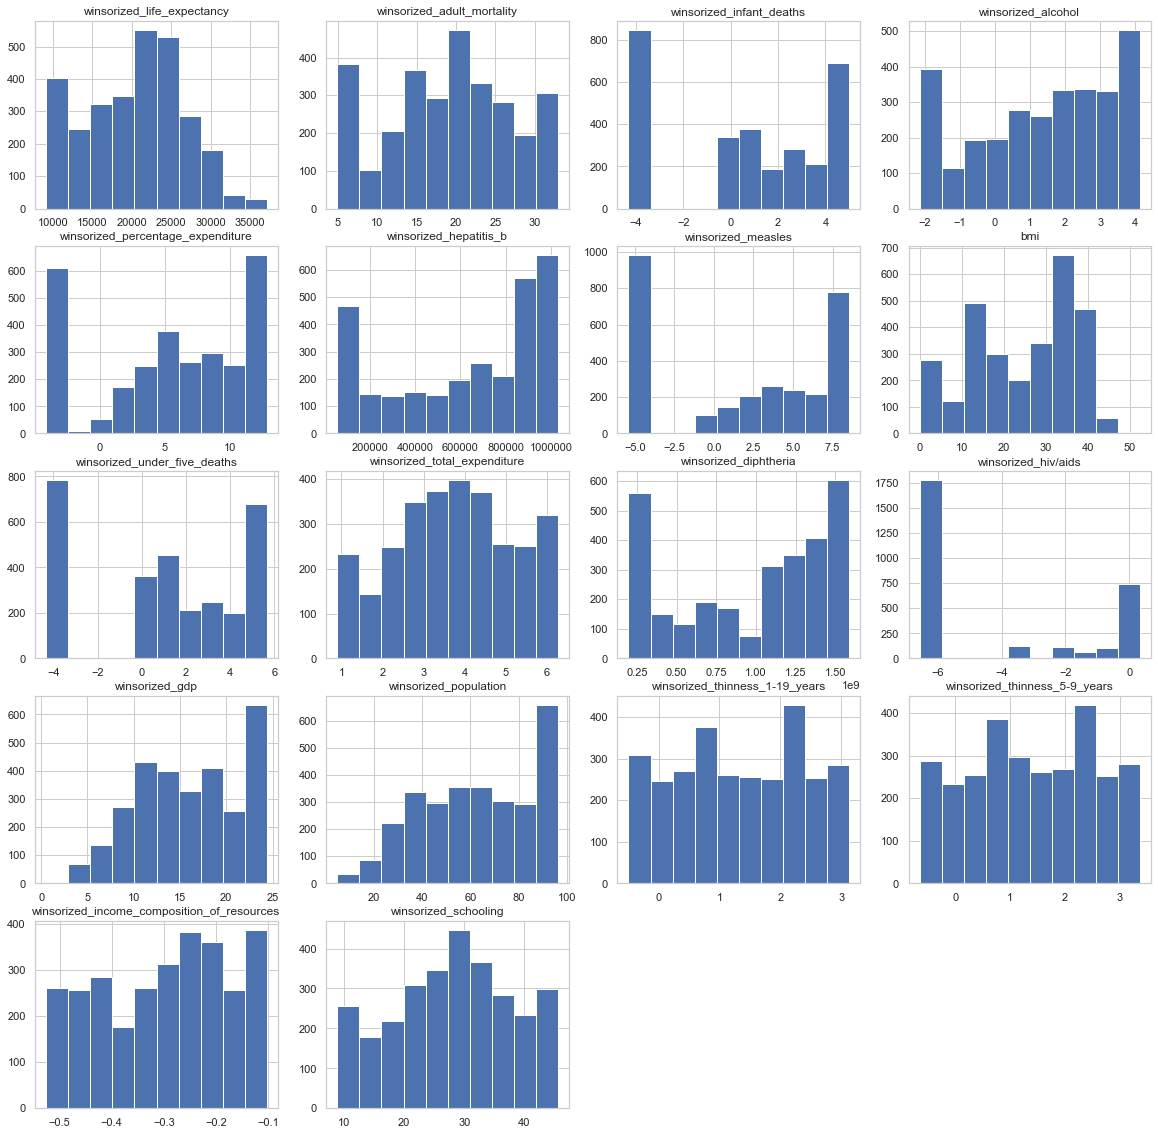

In [28]:
plt.figure(figsize=(20,20))

for i, column in enumerate(winsorized_list, start = 1):
    plt.subplot(5, 4, i)
    plt.hist(box_cox_df[column])
    plt.title(column)
    
plt.show()


None of these distributions can be considered normal, however some are relatively close, based on the histograms above. However, their distributions are considerably closer than before boxcox transformation.

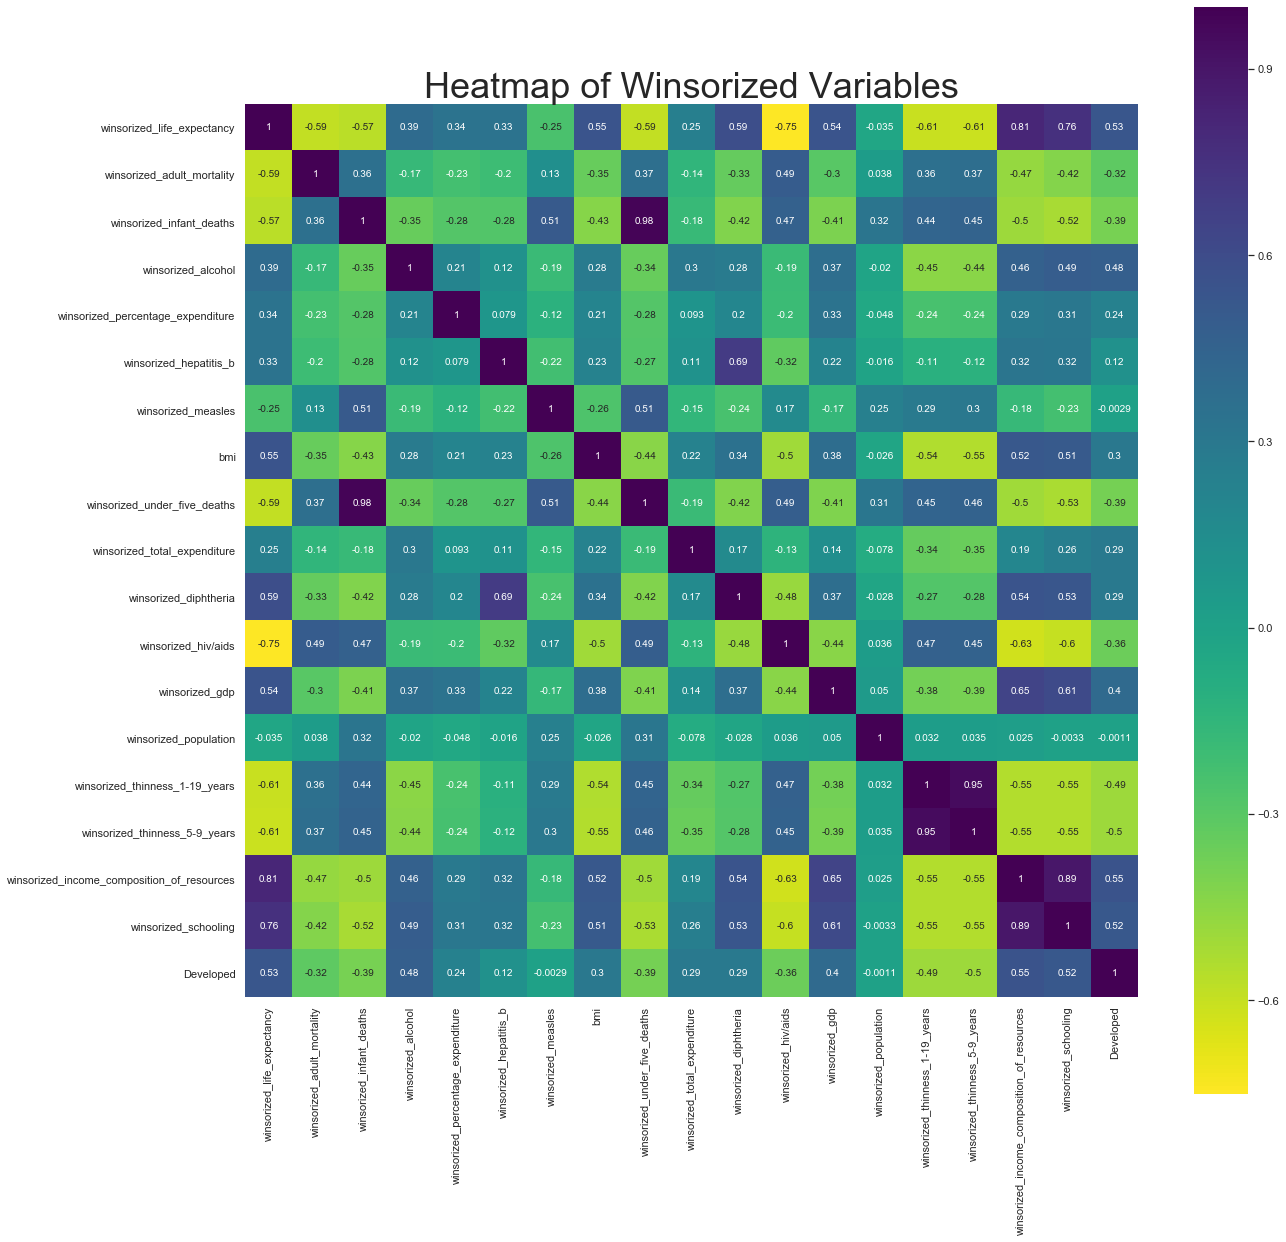

In [29]:
#Create a heatmap to visualize correlations among winsorized variables:

winsorized_list.append('Developed')

heatmap = box_cox_df[winsorized_list].corr()
plt.figure(figsize=(20,20))
sns.heatmap(heatmap, square=True, annot=True, cmap='viridis_r')
plt.title('Heatmap of Winsorized Variables', fontsize=36)

plt.show()

In [30]:
#Of relevant variables, those with positive or negative correlation with life expectancy, only the following
#have normal enough distributions for PCA:
#adult mortality, and bmi

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Remove 'winsorized_hiv/aids' because of high correlation with 'status':
features_df = pd.concat([life_expectancy_df2['winsorized_adult_mortality'],
                         life_expectancy_df2['bmi']], axis=1)

X = features_df
#print(features_df.head())
X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
features_df['pca_1'] = sklearn_pca.fit_transform(X)

print('The percentage of total variance in the dataset explained by each component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_)


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.69923649]


The features included in this dataset are seen below:

In [31]:
features_df = pd.concat([features_df['pca_1'],
                         life_expectancy_df2['winsorized_hiv/aids'],
                         life_expectancy_df2['winsorized_schooling'],
                         life_expectancy_df2['winsorized_thinness_1-19_years'],
                         life_expectancy_df2['winsorized_under_five_deaths'],
                         life_expectancy_df2['winsorized_diphtheria'],
                         pd.get_dummies(life_expectancy_df2['status'])], axis=1)


Features were selected based on strength of correlations to life expectancy. Schooling, and income composition of resources both had high correlations to life expectancy. However, they were more highly correlated with each other. Therefore, the schooling variable was selected as a feature, as it had a close to normal distribution and having both variables included would be redundant. The case with thinness between the ages of five to nine and one to nineteen was the same. In this instance, thinness between the age of one to nineteen was chosen. Other selected features with high correlation included: hiv/aids, diptheria, and status (developed or developing).

Ultimately, variables with significance to life expectancy were chosen.

In [32]:
features_df.head()

pca_1  winsorized_hiv/aids  winsorized_schooling  \
0  1.342532                  0.1                  10.1   
1  1.411699                  0.1                  10.0   
2  1.410083                  0.1                   9.9   
3  1.453511                  0.1                   9.8   
4  1.486966                  0.1                   9.5   

   winsorized_thinness_1-19_years  winsorized_under_five_deaths  \
0                            13.9                            61   
1                            13.9                            61   
2                            13.9                            61   
3                            13.9                            61   
4                            13.9                            61   

   winsorized_diphtheria  Developed  Developing  
0                   65.0          0           1  
1                   65.0          0           1  
2                   65.0          0           1  
3                   67.0          0           1  
4                   68.0          0           1